Extracting files...


<ipython-input-10-6be15cea3619>:46: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.geometry.centroid.y.between(sarnia_bounds['min_lat'], sarnia_bounds['max_lat']) &
<ipython-input-10-6be15cea3619>:47: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.geometry.centroid.x.between(sarnia_bounds['min_lon'], sarnia_bounds['max_lon'])


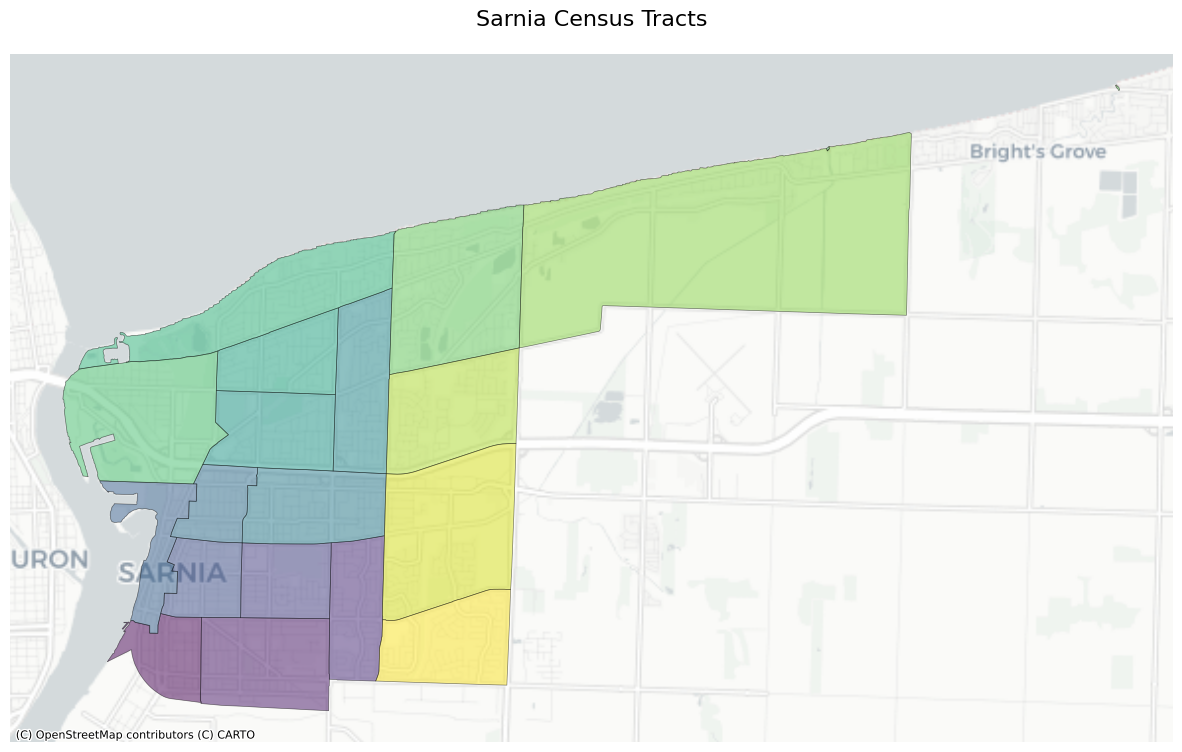

In [10]:
import os
import requests
import zipfile
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

def download_census_tracts():
    """
    Downloads and extracts Sarnia census tract boundaries.
    Returns the path to the extracted shapefile.
    """
    if not os.path.exists('data'):
        os.makedirs('data')

    print("Downloading census tract boundaries...")
    url = "https://www12.statcan.gc.ca/census-recensement/2021/geo/sip-pis/boundary-limites/files-fichiers/lct_000b21a_e.zip"
    zip_path = "data/census_tracts.zip"

    if not os.path.exists(zip_path):
        response = requests.get(url, stream=True)
        with open(zip_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)

    print("Extracting files...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('data')

    return 'data/lct_000b21a_e.shp'

def get_sarnia_tracts(shapefile_path):
    """Load and filter Sarnia census tracts"""
    gdf = gpd.read_file(shapefile_path)
    gdf = gdf.to_crs('EPSG:4326')

    # Filter for Sarnia area
    sarnia_bounds = {
        'min_lat': 42.95,
        'max_lat': 43.05,
        'min_lon': -82.45,
        'max_lon': -82.30
    }

    sarnia_mask = (
        gdf.geometry.centroid.y.between(sarnia_bounds['min_lat'], sarnia_bounds['max_lat']) &
        gdf.geometry.centroid.x.between(sarnia_bounds['min_lon'], sarnia_bounds['max_lon'])
    )

    return gdf[sarnia_mask].copy()

def visualize_census_tracts(sarnia_tracts):
    """Create visualization of census tracts"""
    # Convert to Web Mercator for the basemap
    sarnia_tracts_web = sarnia_tracts.to_crs(epsg=3857)

    # Create figure
    fig, ax = plt.subplots(figsize=(15, 15))

    # Plot tracts
    sarnia_tracts_web.plot(
        ax=ax,
        alpha=0.5,
        edgecolor='black',
        linewidth=0.5,
        column='CTUID',
        cmap='viridis',
        legend=False
    )

    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

    # Customize plot
    ax.set_axis_off()
    plt.title('Sarnia Census Tracts', fontsize=16, pad=20)

    plt.show()

    return sarnia_tracts

# Execute visualization
shapefile_path = download_census_tracts()
sarnia_tracts = get_sarnia_tracts(shapefile_path)
sarnia_tracts = visualize_census_tracts(sarnia_tracts)